In [500]:
# overhead

import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt
import matplotlib.animation as animation

logger = logging.getLogger(__name__)

In [501]:
# environment parameters

FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 0.12  # gravity constant
BOOST_ACCEL = 0.18  # thrust constant

# # the following parameters are not being used in the sample code
PLATFORM_WIDTH = 0.25  # landing platform width
PLATFORM_HEIGHT = 0.  # landing platform height
w1 = [-PLATFORM_WIDTH, PLATFORM_WIDTH]
w2 = [0.1*-PLATFORM_WIDTH, 0.1*PLATFORM_WIDTH]
h = [PLATFORM_HEIGHT, PLATFORM_HEIGHT]
ROTATION_ACCEL = np.radians(20)  # rotation constant

In [502]:
# define system dynamics
# Notes:
# 0. You only need to modify the "forward" function
# 1. All variables in "forward" need to be PyTorch tensors.
# 2. All math operations in "forward" has to be differentiable, e.g., default PyTorch functions.
# 3. Do not use inplace operations, e.g., x += 1. Please see the following section for an example that does not work.

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action: thrust or no thrust
        state[0] = y
        state[1] = y_dot
        """

        delta_state_ori = ROTATION_ACCEL* FRAME_TIME*t.tensor([0., 1, 0., 0., 0., 0.])

        sin = t.matmul(t.tensor([[0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [-1., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.]]),t.sin(t.transpose(state,0,1)))
        cos = t.matmul(t.tensor([[0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [1., 0., 0., 0., 0., 0.]]),t.cos(t.transpose(state,0,1)))
        cos_sin = cos+sin
        cos_sin = t.transpose(cos_sin,0,1)
        delta_state_pos = BOOST_ACCEL* FRAME_TIME*t.tensor([0., 0., 0., 1., 0., 1.])*cos_sin # x and y components of acceleration

        delta_state_combine = delta_state_ori + delta_state_pos

        action_mat = t.tensor([[0., 0.],
                         [2., 0.],
                         [0., 0.],
                         [0., 1.],
                         [0., 0.],
                         [0., 1.]])

        a_a = t.add(t.transpose(t.matmul(action_mat, t.transpose(action,0,1)),0,1) , t.tensor([0., -1., 0., 0., 0., 0.]))# get ori and pos accelerations

        delta_state = delta_state_combine*a_a

        state_gravity = GRAVITY_ACCEL * FRAME_TIME*t.tensor([0., 0., 0., 0., 0., -1.])
        state = state + delta_state + state_gravity

        step_mat = t.tensor([[1., FRAME_TIME, 0., 0., 0., 0.],
                             [0., 1., 0., 0., 0., 0.],
                             [0., 0., 1., FRAME_TIME, 0., 0.],
                             [0., 0., 0., 1., 0., 0.],
                             [0., 0., 0., 0., 1., FRAME_TIME,],
                             [0., 0., 0., 0., 0., 1.]])
        state = t.transpose(t.matmul(step_mat, t.transpose(state,0,1)),0,1)

        return state

In [503]:
# a deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden1, dim_hidden2, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden1),
            nn.Tanh(),
            nn.Linear(dim_hidden1, dim_hidden2),
            nn.Tanh(),
            nn.Linear(dim_hidden2, dim_output),
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action

In [504]:
# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T, n):
        super(Simulation, self).__init__()
        self.T = T
        self.state = self.initialize_state(n)
        self.controller = controller
        self.dynamics = dynamics
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state,n):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state,n)

    @staticmethod
    def initialize_state(n):
        print('ini',n)
        initial = np.zeros((n,6))
        for i in range(n):
            initial[i] = [0.5*math.pi*(random.random()-0.5), 0.1*math.pi*(random.random()-0.5), # orientation state
                     (random.random()-0.5), 0.1*(random.random()-0.5), # horizontal state
                     0.5*random.random()+1, -0.1*random.random()]  # vertical state
        print('Generate %d initial states of rocket:' % n)
        print(initial)
        return t.tensor(initial, requires_grad=False).float()
    def error(self, state, n):
        states = t.square(state).sum(dim=0)*t.tensor([1., 1., 0.01, 1., 1., 1.]) # weight of each state
        return states.sum(dim=0)/n

In [505]:
# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial states to consider simultaneously)
# 1. You can also try SGD and other momentum-based methods implemented in PyTorch
# 2. You will need to customize "visualize"
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self,n):
        def closure():
            loss = self.simulation(self.simulation.state,n)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()

    def train(self, eps, max_epoch, n):
        conv_log = []
        conv_itr = []
        epoch = 0
        error = 100
        print('Start Training:')
        while error > eps and epoch <= max_epoch:
            loss = self.step(n)
            conv_log.append(loss.item())
            conv_itr.append(epoch)
            epoch += 1
            print('[%d] loss: %.6f' % (epoch, loss))
            error = loss.item()
        #     cord = self.visualize()
        # print('Landing Trajectory:')
        # for r in range(N):
        #     plt.quiver(cord[:,r, 2], cord[:,r, 4], -0.05*np.sin(cord[:,r, 0]), 0.05*np.cos(cord[:,r, 0]))
        #     plt.quiver(cord[-1,r, 2], cord[-1,r, 4], -0.05*np.sin(cord[-1,r, 0]), 0.05*np.cos(cord[-1,r, 0]),color='orange')
        #     plt.plot(w1, h, color="red", linewidth=3)
        #     plt.plot(w2, h, color="green", linewidth=3)
        #     plt.show()
        print('Convergence Plot:')
        plt.plot(conv_itr, conv_log)
        plt.yscale("log")
        plt.show()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        plt.scatter(data[:,0,2], data[:,0,4],s=5)
        plt.plot(w1, h, color="red", linewidth=3)
        plt.plot(w2, h, color="green", linewidth=3)
        plt.show()
        return data

In [506]:
class Evaluation:
    def __init__(self, simulation):
        self.simulation = simulation

    def test(self, n):
        print('Start Testing:')
        loss = self.simulation(self.simulation.state,n)
        print('loss: %.6f' % loss)
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        print('Landing Trajectory:')
        for r in range(n):
            plt.quiver(data[:,r, 2], data[:,r, 4], -0.05*np.sin(data[:,r, 0]), 0.05*np.cos(data[:,r, 0]))
            plt.quiver(data[-1,r, 2], data[-1,r, 4], -0.05*np.sin(data[-1,r, 0]), 0.05*np.cos(data[-1,r, 0]),color='orange')
            plt.plot(w1, h, color="red", linewidth=3)
            plt.plot(w2, h, color="green", linewidth=3)
            plt.show()
            end = data[-1,r,:]
            print(np.abs(end))

ini 100
Generate 100 initial states of rocket:
[[-7.25541463e-01 -4.27580731e-02  1.09823759e-01  2.29932600e-02
   1.16449255e+00 -5.03974301e-02]
 [ 5.57736484e-01  1.09149733e-01  4.14549471e-01 -2.41373149e-02
   1.13161222e+00 -2.93329901e-03]
 [-6.36819614e-01 -7.24664226e-02  2.70192361e-02 -2.42316848e-02
   1.05092366e+00 -1.86751421e-02]
 [-7.64151593e-01  1.44401140e-01  1.84404500e-01 -9.05502986e-03
   1.02980978e+00 -5.31167507e-02]
 [ 5.82264538e-01 -6.89405198e-02  4.91384104e-01  3.70715153e-02
   1.04997626e+00 -8.61252588e-02]
 [ 4.61183919e-01 -3.37776124e-02 -3.82656524e-01 -4.97198968e-03
   1.35798843e+00 -1.57445616e-02]
 [-1.32825911e-01  2.61838227e-02  2.33926149e-01 -4.62978370e-02
   1.14586023e+00 -6.14894737e-02]
 [-6.83768282e-01  1.41222658e-01  4.97043488e-01 -5.99844694e-03
   1.33214870e+00 -6.41364917e-02]
 [ 3.87425258e-01 -2.69613325e-02 -2.86700688e-02  7.02764515e-03
   1.41878851e+00 -1.46708432e-02]
 [-5.87403776e-01 -9.46608867e-02  4.1256788

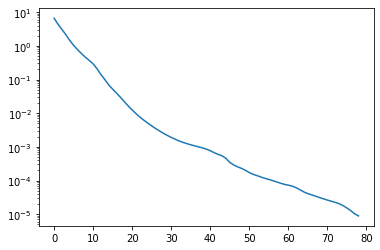

In [507]:
# Now it's time to run the code!

T = 100  # number of time steps
N = 100  # number of initial states
err = 0.00001 # acceptable_error
itr = 150 # max_iteration
dim_input = 6  # state space dimensions
dim_hidden1 = 12  # latent dimensions
dim_hidden2 = 4  # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden1, dim_hidden2, dim_output)  # define controller
s = Simulation(c, d, T, N)  # define simulation
o = Optimize(s)  # define optimizer
o.train(err,itr,N)  # solve the optimization problem

path = './Landing_Model.pth' # save model
t.save(c.state_dict(),path)

ini 10
Generate 10 initial states of rocket:
[[-2.28454392e-01  7.62482724e-02 -4.51154678e-01 -4.06068045e-02
   1.17667563e+00 -6.59241280e-02]
 [-1.99211311e-01  1.12620201e-01  1.24871633e-01  4.86588520e-02
   1.43588748e+00 -8.02364949e-02]
 [-2.43355298e-01 -7.15576688e-02  4.48701859e-01  3.73606349e-02
   1.43097654e+00 -9.32680879e-02]
 [ 6.35813880e-01  4.24919694e-02  1.23832096e-01 -3.76031843e-02
   1.34555037e+00 -6.55432858e-02]
 [-2.31289717e-01 -1.15470767e-01 -3.21001987e-01 -1.76744336e-02
   1.06933148e+00 -7.55047862e-02]
 [ 1.52687108e-01 -1.05016876e-02 -1.32387482e-01  6.51710501e-04
   1.38284301e+00 -8.93593336e-02]
 [-3.98916020e-01  1.04700547e-01  3.00761740e-01  1.34757575e-02
   1.07826684e+00 -6.53646929e-02]
 [ 1.45877078e-01  3.32144182e-02 -3.59440293e-01 -4.75142827e-02
   1.20083683e+00 -2.20409594e-02]
 [-5.60611772e-01 -8.62240107e-03 -2.97145331e-01 -5.37002106e-04
   1.30007849e+00 -2.47182738e-03]
 [-4.83093782e-01 -1.31876714e-01 -2.25629936e

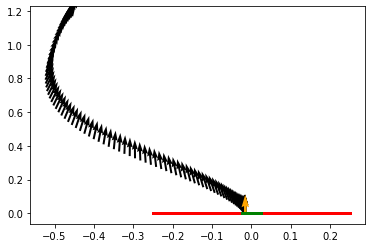

[2.2587155e-03 8.2596118e-05 1.5415080e-02 1.0865155e-03 5.9842394e-04
 1.1486653e-04]


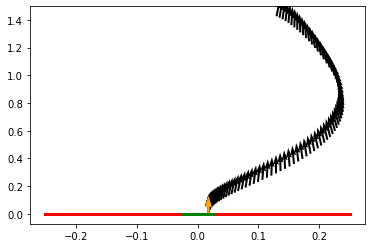

[1.2644182e-03 9.7111467e-04 1.7740794e-02 3.3453741e-04 8.9286521e-05
 2.9582530e-04]


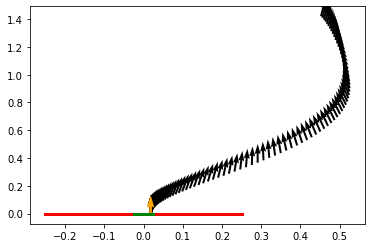

[0.00265887 0.00073615 0.01818003 0.00104098 0.00120549 0.00191181]


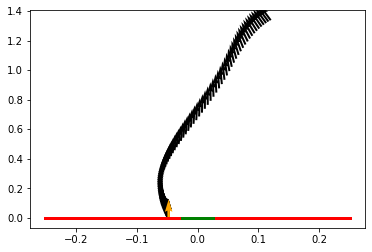

[6.0335638e-05 5.5130856e-04 4.7528725e-02 1.2523520e-03 4.2710442e-04
 1.9784877e-03]


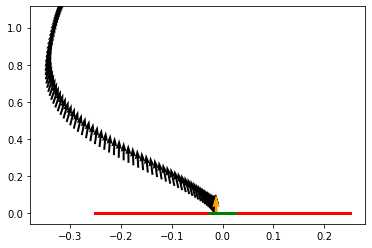

[1.0096459e-03 5.1180198e-04 1.2610770e-02 7.0307922e-04 4.0741166e-04
 2.2679567e-05]


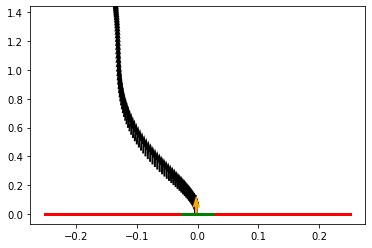

[1.1842861e-03 6.2574097e-04 2.2813596e-03 4.0984852e-04 4.7190537e-05
 1.6863272e-04]


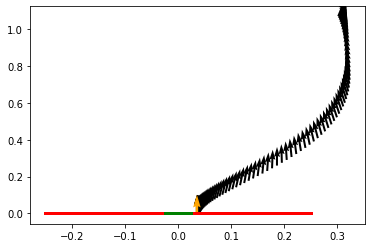

[0.00086268 0.00057443 0.03559679 0.00154957 0.00011679 0.00072647]


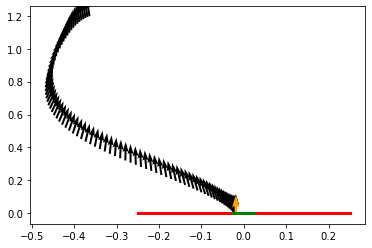

[0.00188407 0.00059515 0.01861273 0.00119068 0.00043921 0.00034162]


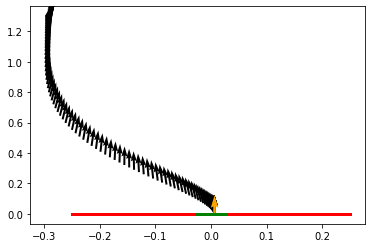

[5.2406732e-04 7.8543369e-04 6.4133680e-03 5.6944216e-05 1.3019863e-04
 3.4346897e-04]


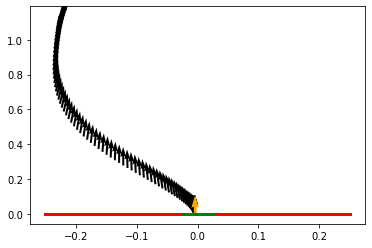

[1.7806154e-03 8.5247168e-04 4.1057486e-03 5.8432290e-04 1.6790348e-04
 8.9668669e-05]


In [508]:
# Test the control model by some new samples:

N_eval = 10 # number of initial states for testing
d_eval = Dynamics()  # define dynamics
model_eval =  Controller(dim_input, dim_hidden1, dim_hidden2, dim_output) # define controller

path = './Landing_Model.pth' # load model
model_eval.load_state_dict(t.load(path))
model_eval.eval()

s_eval = Simulation(model_eval, d_eval, T, N_eval )
eva = Evaluation(s_eval)  # initial evaluation simulator
eva.test(N_eval) # Test